In [1]:
num_experiments = 10
observation_sizes = [100, 1000, 2000]
num_cv = 5

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics.pairwise import rbf_kernel
from scipy.spatial.distance import pdist
from Environment import AvgEnvironment
from Policy import MultinomialPolicy
from ParameterSelector import ParameterSelector

2025-05-12 14:51:34.781671: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747057894.802291   58703 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747057894.809271   58703 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747057894.825072   58703 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747057894.825089   58703 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747057894.825091   58703 computation_placer.cc:177] computation placer alr

In [2]:
from sklearn import preprocessing

def data_transform(X, scaler_type = "Standard"):

    if scaler_type == "Standard":
        scaler = preprocessing.StandardScaler()
    elif scaler_type == "MinMax":
        scaler = preprocessing.MinMaxScaler()
    else:
        raise Exception("Scaler type can be either Standard or MinMax!")
    if X.ndim == 1:
        X_scaled = scaler.fit_transform(X.reshape(-1,1)).squeeze()
        return X_scaled, scaler
    else:
        X_scaled = scaler.fit_transform(X).squeeze()
        return X_scaled, scaler

# A_transformed, A_transformer = data_transform(A)

In [3]:
import jax.numpy as jnp
import numpy as np

from kernel import Exponential, Gaussian, Linear, Polynomial, RationalQuadratic

settings = {"reg_lambda": 1e-5, "bandwidth": 1}


def _get_kernel(settings):
    if settings["kernel"] == "gauss":
        kernel = Gaussian(settings)
        return kernel
    elif settings["kernel"] == "exp":
        kernel = Exponential(settings)
        return kernel
    elif settings["kernel"] == "linear":
        return Linear(settings)
    elif settings["kernel"] == "polynomial":
        return Polynomial(settings)
    elif settings["kernel"] == "rq":
        return RationalQuadratic(settings)
    else:
        raise NotImplementedError

In [10]:
from Policy import *
from scipy.optimize import lsq_linear, nnls
from scipy.spatial.distance import pdist
import tensorflow as tf

class Estimator(object):
    @abstractmethod
    def estimate(self, sim_data):
        pass

    @property
    @abstractmethod
    def name(self):
        pass

class DirectEstimator(Estimator):
    def __init__(self):
        self.model = None
        self.params = None

    @property
    def name(self):
        return "Direct"

    def fit(self, features, rewards, n_hidden_units=100, batch_size=64, epochs=10):
        input_dim = features.shape[1]
        self.model = tf.keras.Sequential([
            tf.keras.layers.Dense(n_hidden_units, activation="relu", input_shape=(input_dim,)),
            tf.keras.layers.Dense(1),
        ])
        self.model.compile(optimizer="adam", loss="mse")
        self.model.fit(features, rewards, batch_size=batch_size, epochs=epochs, verbose=0)

    def estimate(self, sim_data):
        sim_data = sim_data.copy()

        target_context_vec = sim_data["target_context_vec"].dropna(axis=0)
        target_reco_vec = sim_data["target_reco_vec"].dropna(axis=0)

        X_target = np.hstack([
            np.vstack(target_context_vec.values),
            np.vstack(target_reco_vec.values)
        ])
        pred_rewards = self.model.predict(X_target, batch_size=256, verbose=0)
        return np.mean(pred_rewards)

    def set_parameters(self, params):
        self.params = params

class IPSEstimator(Estimator):
    def __init__(self, behavior_estimator, target_policy):
        self.behavior_estimator = behavior_estimator
        self.target_policy = target_policy

    @property
    def name(self):
        return "ips_estimator"

    def calculate_weight(self, row):
        logging_prob = self.behavior_estimator.predict_proba(row.logging_context_vec, row.logging_reco[0])
        if not self.target_policy.greedy:
            target_prob = self.target_policy.get_propensity(row.target_multinomial, row.logging_reco)
        else:
            target_prob = 1.0 if row.logging_reco == row.target_reco else 0.0

        if logging_prob == 0:
            return 0.0
        return np.clip(target_prob / logging_prob, 0, 10)  # Clip for stability

    def estimate(self, sim_data):
        sim_data["ips_w"] = sim_data.apply(self.calculate_weight, axis=1)
        #print(sim_data["ips_w"])
        exp_reward = np.mean(sim_data["ips_w"] * sim_data["logging_reward"])
        exp_weight = np.mean(sim_data["ips_w"])
        return exp_reward / exp_weight

class DoublyRobustEstimator(Estimator):
    def __init__(self, behavior_estimator, target_policy, params=(100, 1024, 100)):
        self.behavior_estimator = behavior_estimator
        self.target_policy = target_policy
        self.params = params
        self.model = None

    @property
    def name(self):
        return "doubly robust estimator"

    def fit(self, features, rewards):
        input_dim = features.shape[1]
        n_hidden_units = self.params[0]
        self.model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(input_dim,)),
            tf.keras.layers.Dense(n_hidden_units, activation="relu"),
            tf.keras.layers.Dense(1),
        ])
        self.model.compile(optimizer="adam", loss="mse")
        self.model.fit(features, rewards, batch_size=self.params[1], epochs=self.params[2], verbose=0)

    def calculate_weight(self, row):
        logging_prob = self.behavior_estimator.predict_proba(row.logging_context_vec, row.logging_reco[0])
        if not self.target_policy.greedy:
            target_prob = self.target_policy.get_propensity(row.target_multinomial, row.logging_reco)
        else:
            target_prob = 1.0 if row.logging_reco == row.target_reco else 0.0

        if logging_prob == 0:
            return 0.0
        return np.clip(target_prob / logging_prob, 0, 10)

    def estimate(self, sim_data):
        sim_data = sim_data.copy()

        logging_context_vec = sim_data["logging_context_vec"].dropna(axis=0)
        logging_reco_vec = sim_data["logging_reco_vec"].dropna(axis=0)
        logging_reward = sim_data["logging_reward"].dropna(axis=0)
        target_context_vec = sim_data["target_context_vec"].dropna(axis=0)
        target_reco_vec = sim_data["target_reco_vec"].dropna(axis=0)

        X_logging = np.hstack([
            np.vstack(logging_context_vec.values),
            np.vstack(logging_reco_vec.values)
        ])
        X_target = np.hstack([
            np.vstack(target_context_vec.values),
            np.vstack(target_reco_vec.values)
        ])

        self.fit(X_logging, logging_reward.values)

        logging_predictions = self.model.predict(X_logging, batch_size=256).flatten()
        target_predictions = self.model.predict(X_target, batch_size=256).flatten()

        ips_w = sim_data.apply(self.calculate_weight, axis=1)

        estimated_reward = target_predictions + (logging_reward.values - logging_predictions) * ips_w
        print("doubly robust estimator ips_w", ips_w)
        print("doubly robust estimator ips_w max", np.max(ips_w))
        return np.mean(estimated_reward)

class CMEstimator(Estimator):
    @property
    def name(self):
        return "cme_estimator"

    def __init__(self, context_kernel, recom_kernel, params):
        """
        :param context_kernel: the kernel function for the context variable
        :param recom_kernel: the kernel function for the recommendation
        :param params: all parameters including regularization parameter and kernel parameters
        """
        self.context_kernel = context_kernel
        self.recom_kernel = recom_kernel
        self._params = params

    @property
    def params(self):
        return self._params

    @params.setter
    def params(self, value):
        self._params = value

    def estimate(self, sim_data):
        """
        Calculate and return a coefficient vector (beta) of the counterfactual mean embedding of reward distribution.
        """

        # extract the regularization and kernel parameters
        reg_param = self.params[0]
        context_param = self.params[1]
        recom_param = self.params[2]

        logging_reward = sim_data.logging_reward.dropna(axis=0)

        logging_context_vec = np.stack(
            sim_data["logging_context_vec"].dropna(axis=0).to_numpy()
        )
        logging_reco_vec = np.stack(
            sim_data["logging_reco_vec"].dropna(axis=0).to_numpy()
        )
        target_context_vec = np.stack(
            sim_data["target_context_vec"].dropna(axis=0).to_numpy()
        )
        target_reco_vec = np.stack(
            sim_data["target_reco_vec"].dropna(axis=0).to_numpy()
        )

        # safe median heuristic for the bandwidth parameters
        context_dists = pdist(
            np.vstack([logging_context_vec, target_context_vec]), "sqeuclidean"
        )
        context_median = np.median(context_dists)
        if context_median == 0.0:
            context_param = 1.0
        else:
            context_param = (0.5 * context_param) / context_median

        recom_dists = pdist(
            np.vstack([logging_reco_vec, target_reco_vec]), "sqeuclidean"
        )
        recom_median = np.median(recom_dists)
        if recom_median == 0.0:
            recom_param = 1.0
        else:
            recom_param = (0.5 * recom_param) / recom_median

        contextMatrix = self.context_kernel(
            logging_context_vec, logging_context_vec, context_param
        )
        recomMatrix = self.recom_kernel(logging_reco_vec, logging_reco_vec, recom_param)

        targetContextMatrix = self.context_kernel(
            logging_context_vec, target_context_vec, context_param
        )
        targetRecomMatrix = self.recom_kernel(
            logging_reco_vec, target_reco_vec, recom_param
        )

        # calculate the coefficient vector using the pointwise product kernel L_ij = K_ij.G_ij
        m = sim_data["target_reco"].dropna(axis=0).shape[0]
        n = sim_data["logging_reco"].dropna(axis=0).shape[0]
        b = np.dot(
            np.multiply(targetContextMatrix, targetRecomMatrix),
            np.repeat(1.0 / m, m, axis=0),
        )

        # solve a linear least-square
        A = np.multiply(contextMatrix, recomMatrix) + np.diag(
            np.repeat(n * reg_param, n)
        )
        beta_vec, _ = scipy.sparse.linalg.cg(A, b, tol=1e-06)

        # return the expected reward as an average of the rewards, obtained from the logging policy,
        # weighted by the coefficients beta from the counterfactual mean estimator.
        return np.dot(beta_vec, logging_reward) / beta_vec.sum()
    

class CMEbis(Estimator):

    @property
    def name(self):
        return "cmebis"

    def __init__(self, context_kernel, recom_kernel, params,
                optimize_regularizer = True,
                 reg_optimization_range = (1e-7, 0.1),
                 **kwargs,):
        """
        :param context_kernel: the kernel function for the context variable
        :param recom_kernel: the kernel function for the recommendation
        :param params: all parameters including regularization parameter and kernel parameters
        """
        self.context_kernel = context_kernel
        self.recom_kernel = recom_kernel
        self._params = params
        self.optimize_regularizer = optimize_regularizer
        self.reg_optimization_range = reg_optimization_range
        self.model = None
        self.regularization_grid_points = kwargs.pop('regularization_grid_points', 25)
        
    @property
    def params(self):
        return self._params

    @params.setter
    def params(self, value):
        self._params = value

    def conditional_mean_embedding_regularization_loss(self, reg_lambda_, K_in, K_out):
        """
        See algorithm 7 in https://arxiv.org/abs/2012.10315
        Kernel Methods for Unobserved Confounding: Negative Controls, Proxies, and Instruments by Rahul Singh

        Compute the conditional mean embedding regularization loss.

        Parameters:
        - reg_lambda_ (float): Regularization parameter.
        - K_in (jnp.ndarray): Kernel matrix for input variables.
        - K_out (jnp.ndarray): Kernel matrix for target values Y.

        Returns:
        - float: Conditional mean embedding regularization loss.
        """
        n = K_in.shape[0]
        R = K_in @ np.linalg.inv((K_in) + n * reg_lambda_ * np.eye(n))
        S = np.diag((1 / (1 - np.diag(R))) ** 2)
        T = S @ (K_out - 2 * K_out @ R.T + R @ K_out @ R.T)
        cost = np.trace(T)
        return cost
        
    def estimate(self, sim_data):
        settings = {
        'kernel': 'gauss',
        'bandwidth': 0.1,
        }
        reg_param = self.params[0]
        context_param = self.params[1]
        recom_param = self.params[2]

        logging_reward = sim_data.logging_reward.dropna(axis=0)

        logging_context_vec = np.stack(
            sim_data["logging_context_vec"].dropna(axis=0).to_numpy()
        )
        logging_reco_vec = np.stack(
            sim_data["logging_reco_vec"].dropna(axis=0).to_numpy()
        )
        target_context_vec = np.stack(
            sim_data["target_context_vec"].dropna(axis=0).to_numpy()
        )
        target_reco_vec = np.stack(
            sim_data["target_reco_vec"].dropna(axis=0).to_numpy()
        )

        # kernel_treatment = _get_kernel(settings)
        # kernel_covariates = _get_kernel(settings)

        # kernel_treatment.fit(logging_reco_vec)
        # kernel_treatment._sigma *= recom_param
        # kernel_covariates.fit(logging_context_vec)
        # kernel_covariates._sigma *= context_param

        # K_T = kernel_treatment.gram_matrix(logging_reco_vec)
        # K_X = kernel_covariates.gram_matrix(logging_context_vec)

        # K_T_tilde = kernel_treatment.evaluate(logging_reco_vec, target_reco_vec)
        # K_X_tilde = kernel_covariates.evaluate(logging_context_vec, target_context_vec)

        context_dists = pdist(
            np.vstack([logging_context_vec, target_context_vec]), "sqeuclidean"
        )
        # recom_dists = pdist(
        #     np.vstack([logging_reco_vec, target_reco_vec]), "sqeuclidean"
        # )
        recom_dists = pdist(
            np.vstack([logging_reco_vec, logging_reco_vec]), "sqeuclidean"
        )
        context_median = np.median(context_dists)
        recom_median = np.median(recom_dists)

        if context_median == 0.0:
            context_param = 1.0
        else:
            context_param = (0.5 * context_param) / context_median

        if recom_median == 0.0:
            recom_param = 1.0
        else:
            recom_param = (0.5 * recom_param) / recom_median


        n = logging_context_vec.shape[0]

        K_X = self.context_kernel(
            logging_context_vec, logging_context_vec, context_param
        )
        K_T = self.recom_kernel(logging_reco_vec, logging_reco_vec, recom_param)
        K_X_tilde = self.context_kernel(
            logging_context_vec, target_context_vec, context_param
        )
        K_T_tilde = self.recom_kernel(
            logging_reco_vec, target_reco_vec, recom_param
        )

        if self.optimize_regularizer:
            # reg_optimization_range = self.reg_optimization_range
            # regularization_grid_points = self.regularization_grid_points
            # K_TX = K_T * K_X
            # K_TX_tilde = K_T_tilde * K_X_tilde
            # lambda_list = np.logspace(np.log(reg_optimization_range[0]), np.log(reg_optimization_range[1]), regularization_grid_points, base = np.exp(1))
            # ridge_penaly_loss_list = np.array([self.ridge_regularizer_loss(lambda_, K_TX, K_TX, logging_reward.values) for lambda_ in lambda_list])
            # reg_param = lambda_list[np.argmin(ridge_penaly_loss_list).item()]
            # self.reg_param = reg_param
            # plt.semilogx(np.array(lambda_list), ridge_penaly_loss_list)
            # plt.show()

            reg_optimization_range = self.reg_optimization_range
            regularization_grid_points = self.regularization_grid_points
            K_in = K_T * K_X
            K_out = logging_reward.values.reshape(-1, 1) @ logging_reward.values.reshape(-1, 1).T
            K_out = (1 - logging_reward.values.reshape(-1, 1)) @ (1 - logging_reward.values.reshape(-1, 1).T)
            lambda_list = np.logspace(np.log(reg_optimization_range[0]), np.log(reg_optimization_range[1]), regularization_grid_points, base = np.exp(1))
            ridge_penaly_loss_list = np.array([self.conditional_mean_embedding_regularization_loss(lambda_, K_in, K_out) for lambda_ in lambda_list])
            reg_param = lambda_list[np.argmin(ridge_penaly_loss_list).item()]
            self.reg_param = reg_param
            # plt.semilogx(np.array(lambda_list), ridge_penaly_loss_list)
            # plt.show()
            
        A_logging = np.multiply(K_X, K_T) + n * reg_param * np.eye(n)
        b_logging = np.multiply(K_T_tilde, K_X_tilde)
        inv_K_tilde_K =  np.linalg.solve(A_logging, b_logging)
        return np.mean(np.dot(logging_reward,inv_K_tilde_K))


class DoublyRobustbis(Estimator):
    def __init__(self, context_kernel, 
                 recom_kernel, 
                 params, 
                 behavior_estimator, 
                 target_policy,
                 optimize_regularizer = True,
                 reg_optimization_range = (1e-7, 0.1),
                 **kwargs,
                 ):
        self.context_kernel = context_kernel
        self.recom_kernel = recom_kernel
        self.behavior_estimator = behavior_estimator
        self.target_policy = target_policy
        self.params = params
        self.optimize_regularizer = optimize_regularizer
        self.reg_optimization_range = reg_optimization_range
        self.model = None
        self.regularization_grid_points = kwargs.pop('regularization_grid_points', 25)

    @property
    def name(self):
        return "dr_bis"


    def ridge_regularizer_loss(self, reg_lambda_, K_TX, K_TX_tilde, Y):
        """
        Compute the ridge penalty loss.
    
        Parameters:
        - reg_lambda_ (float): Regularization parameter.
    
        Returns:
        - float: Ridge penalty loss.
        """
        n = K_TX.shape[0]
        identity = np.eye(n)
        H_alpha = identity - np.linalg.solve((K_TX + n * reg_lambda_ * identity).T, K_TX_tilde.T).T
        H_tilde_alpha_inv = np.diag(1/np.diag(H_alpha))
        loss = (np.linalg.norm(H_tilde_alpha_inv @ H_alpha @ Y) ** 2) # /n
        return loss

    def conditional_mean_embedding_regularization_loss(self, reg_lambda_, K_in, K_out):
        """
        See algorithm 7 in https://arxiv.org/abs/2012.10315
        Kernel Methods for Unobserved Confounding: Negative Controls, Proxies, and Instruments by Rahul Singh

        Compute the conditional mean embedding regularization loss.

        Parameters:
        - reg_lambda_ (float): Regularization parameter.
        - K_in (jnp.ndarray): Kernel matrix for input variables.
        - K_out (jnp.ndarray): Kernel matrix for target values Y.

        Returns:
        - float: Conditional mean embedding regularization loss.
        """
        n = K_in.shape[0]
        R = K_in @ np.linalg.inv((K_in) + n * reg_lambda_ * np.eye(n))
        S = np.diag((1 / (1 - np.diag(R))) ** 2)
        T = S @ (K_out - 2 * K_out @ R.T + R @ K_out @ R.T)
        cost = np.trace(T)
        return cost
        
    def calculate_weight(self, row):
        logging_prob = self.behavior_estimator.predict_proba(row.logging_context_vec, row.logging_reco[0])
        if not self.target_policy.greedy:
            target_prob = self.target_policy.get_propensity(row.target_multinomial, row.logging_reco)
        else:
            target_prob = 1.0 if row.logging_reco == row.target_reco else 0.0

        if logging_prob == 0:
            return 0.0
        return np.clip(target_prob / logging_prob, 0, 10)

    def estimate(self, sim_data):
        sim_data = sim_data.copy()

        settings = {
        'kernel': 'gauss',
        'bandwidth': 0.1,
        }
        reg_param = self.params[0]
        context_param = self.params[1]
        recom_param = self.params[2]

        logging_reward = sim_data.logging_reward.dropna(axis=0)

        logging_context_vec = np.stack(
            sim_data["logging_context_vec"].dropna(axis=0).to_numpy()
        )
        logging_reco_vec = np.stack(
            sim_data["logging_reco_vec"].dropna(axis=0).to_numpy()
        )
        target_context_vec = np.stack(
            sim_data["target_context_vec"].dropna(axis=0).to_numpy()
        )
        target_reco_vec = np.stack(
            sim_data["target_reco_vec"].dropna(axis=0).to_numpy()
        )
        logging_and_target_context_vec_normalized, context_normalizer = data_transform(np.vstack([logging_context_vec, target_context_vec]))
        logging_and_target_recom_vec_normalized, recom_normalizer = data_transform(np.vstack([logging_reco_vec, target_reco_vec]))

        # context_dists = pdist(
        #     np.vstack([logging_context_vec, target_context_vec]), "sqeuclidean"
        # )
        context_dists = pdist(
            logging_and_target_context_vec_normalized, "sqeuclidean"
        )
        recom_dists = pdist(
            logging_and_target_recom_vec_normalized, "sqeuclidean"
        )

        context_median = np.median(context_dists)
        recom_median = np.median(recom_dists)

        if context_median == 0.0:
            context_param = 1.0
        else:
            context_param = (0.5 * context_param) / context_median

        if recom_median == 0.0:
            recom_param = 1.0
        else:
            recom_param = (0.5 * recom_param) / recom_median


        n = logging_context_vec.shape[0]

        K_X = self.context_kernel(
            context_normalizer.transform(logging_context_vec), 
            context_normalizer.transform(logging_context_vec),
            context_param
        )
        K_T = self.recom_kernel(recom_normalizer.transform(logging_reco_vec),
                                recom_normalizer.transform(logging_reco_vec),
                                recom_param)
        K_X_tilde = self.context_kernel(
            context_normalizer.transform(logging_context_vec), 
            context_normalizer.transform(target_context_vec),
            context_param
        )
        K_T_tilde = self.recom_kernel(
            recom_normalizer.transform(logging_reco_vec),
            recom_normalizer.transform(target_reco_vec),
            recom_param
        )
        if self.optimize_regularizer:
            # reg_optimization_range = self.reg_optimization_range
            # regularization_grid_points = self.regularization_grid_points
            # K_TX = K_T * K_X
            # K_TX_tilde = K_T_tilde * K_X_tilde
            # lambda_list = np.logspace(np.log(reg_optimization_range[0]), np.log(reg_optimization_range[1]), regularization_grid_points, base = np.exp(1))
            # ridge_penaly_loss_list = np.array([self.ridge_regularizer_loss(lambda_, K_TX, K_TX, logging_reward.values) for lambda_ in lambda_list])
            # reg_param = lambda_list[np.argmin(ridge_penaly_loss_list).item()]
            # self.reg_param = reg_param
            # plt.semilogx(np.array(lambda_list), ridge_penaly_loss_list)
            # plt.show()

            reg_optimization_range = self.reg_optimization_range
            regularization_grid_points = self.regularization_grid_points
            K_in = K_T * K_X
            K_out = logging_reward.values.reshape(-1, 1) @ logging_reward.values.reshape(-1, 1).T
            K_out += (1 - logging_reward.values.reshape(-1, 1)) @ (1 - logging_reward.values.reshape(-1, 1).T)
            lambda_list = np.logspace(np.log(reg_optimization_range[0]), np.log(reg_optimization_range[1]), regularization_grid_points, base = np.exp(1))
            ridge_penaly_loss_list = np.array([self.conditional_mean_embedding_regularization_loss(lambda_, K_in, K_out) for lambda_ in lambda_list])
            reg_param = lambda_list[np.argmin(ridge_penaly_loss_list).item()]
            self.reg_param = reg_param
            plt.semilogx(np.array(lambda_list), ridge_penaly_loss_list)
            plt.show()
            
        n = logging_context_vec.shape[0]
        A_logging = np.multiply(K_T, K_X) + n * reg_param * np.eye(n)
        b_target = np.multiply(K_T_tilde, K_X_tilde)
        inv_K_tilde_K =  np.linalg.solve(A_logging, b_target)
        target_predictions = np.dot(logging_reward,inv_K_tilde_K)
        # print(target_predictions.shape)
        b_logging = np.multiply(K_T, K_X)
        inv_K_K =  np.linalg.solve(A_logging, b_logging)
        logging_predictions = np.dot(logging_reward, inv_K_K)
    
        ips_w = sim_data.apply(self.calculate_weight, axis=1)
        #print(ips_w)
        #print(np.mean((logging_reward.values - logging_predictions) * ips_w))
        # print(self.reg_param)
        estimated_reward = target_predictions + (logging_reward.values - logging_predictions) * ips_w / np.mean(ips_w)
        # ips_preds = logging_reward.values * ips_w / np.mean(ips_w)
        return np.mean(estimated_reward)
        # return np.mean(ips_preds)
    
class DRCMEstimator(Estimator):
    @property
    def name(self):
        return "dr_cme_estimator"

    def __init__(
        self, context_kernel, recom_kernel, params, behavior_estimator, target_policy
    ):
        self.context_kernel = context_kernel
        self.recom_kernel = recom_kernel
        self._params = params
        self.behavior_estimator = behavior_estimator
        self.target_policy = target_policy
        self.model = None
        print(self._params)

    @property
    def params(self):
        return self._params

    @params.setter
    def params(self, value):
        self._params = value

    def set_parameters(self, params):
        self.params = params

    def estimate(self, sim_data):
        # Extract data
        logging_context_vec = np.stack(
            sim_data["logging_context_vec"].dropna(axis=0).to_numpy()
        )
        logging_reco_vec = np.stack(
            sim_data["logging_reco_vec"].dropna(axis=0).to_numpy()
        )
        target_context_vec = np.stack(
            sim_data["target_context_vec"].dropna(axis=0).to_numpy()
        )
        target_reco_vec = np.stack(
            sim_data["target_reco_vec"].dropna(axis=0).to_numpy()
        )
        logging_reward = sim_data["logging_reward"].dropna(axis=0).values

        # Kernel median heuristic
        reg_param = self.params[0]
        context_param = self.params[1]
        recom_param = self.params[2]
        context_dists = pdist(
            np.vstack([logging_context_vec, target_context_vec]), "sqeuclidean"
        )
        recom_dists = pdist(
            np.vstack([logging_reco_vec, target_reco_vec]), "sqeuclidean"
        )
        context_median = np.median(context_dists)
        recom_median = np.median(recom_dists)

        if context_median == 0.0:
            context_param = 1.0
        else:
            context_param = (0.5 * context_param) / context_median

        if recom_median == 0.0:
            recom_param = 1.0
        else:
            recom_param = (0.5 * recom_param) / recom_median

        contextMatrix = self.context_kernel(
            logging_context_vec, logging_context_vec, context_param
        )
        recomMatrix = self.recom_kernel(logging_reco_vec, logging_reco_vec, recom_param)
        targetContextMatrix = self.context_kernel(
            logging_context_vec, target_context_vec, context_param
        )
        targetRecomMatrix = self.recom_kernel(
            logging_reco_vec, target_reco_vec, recom_param
        )

        m = target_context_vec.shape[0]
        n = logging_context_vec.shape[0]

        b = np.dot(
            np.multiply(targetContextMatrix, targetRecomMatrix),
            np.repeat(1.0 / m, m, axis=0),
        )
        A = np.multiply(contextMatrix, recomMatrix) + np.diag(
            np.repeat(n * reg_param, n)
        )

        beta_vec, _ = scipy.sparse.linalg.cg(A, b, tol=1e-06)
        cme_prediction = np.dot(beta_vec, logging_reward) / beta_vec.sum()

        # Estimate IPS weights
        def calculate_weight(row):
            logging_prob = self.behavior_estimator.predict_proba(row.logging_context_vec, row.logging_reco[0])
            if not self.target_policy.greedy:
                target_prob = self.target_policy.get_propensity(row.target_multinomial, row.logging_reco)
            else:
                target_prob = 1.0 if row.logging_reco == row.target_reco else 0.0
            if logging_prob == 0:
                return 0.0
            return np.clip(target_prob / logging_prob, 0, 10)

        ips_weights = sim_data.apply(calculate_weight, axis=1).values

        # CME estimated rewards at logging points (reweighting)
        b_logging = np.dot(
            np.multiply(contextMatrix, contextMatrix),
            ips_weights,
        )

        # solve a linear least-square
        A_logging = np.multiply(contextMatrix, recomMatrix) + np.diag(
            np.repeat(n * reg_param, n)
        )
        # beta_vec_logging, _ = scipy.sparse.linalg.cg(A_logging, b_logging, tol=1e-06)
        beta_vec_logging = np.linalg.solve(A_logging, b_logging)

        cme_pred_logging = (
            np.dot(beta_vec_logging, logging_reward) / beta_vec_logging.sum()
        )
        # cme_pred_logging = np.dot(beta_vec_logging, logging_reward)
        # DR-CME estimation
        dr_terms = ips_weights * logging_reward / np.mean(
            ips_weights
        ) - cme_pred_logging / np.mean(ips_weights)
        correction = np.mean(dr_terms)

        return correction + cme_prediction


import numpy as np
from sklearn.linear_model import LogisticRegression

class BehaviorPolicyEstimator:
    def __init__(self, n_items):
        self.model = None
        self.n_items = n_items

    def fit(self, user_features, action_indices):
        user_features = np.asarray(user_features)
        action_indices = np.asarray(action_indices)

        if user_features.ndim != 2:
            raise ValueError(f"user_features must be 2D, got {user_features.shape}")
        if action_indices.ndim != 1:
            raise ValueError(f"action_indices must be 1D, got {action_indices.shape}")
        if user_features.shape[0] != action_indices.shape[0]:
            raise ValueError(f"Mismatch: {user_features.shape[0]} samples vs {action_indices.shape[0]} actions")

        self.model = LogisticRegression(
            multi_class='multinomial',
            solver='lbfgs',
            max_iter=1000,
            random_state=42,
        )
        self.model.fit(user_features, action_indices)

    def predict_proba(self, user_feature, action_index):
        user_feature = np.asarray(user_feature)
        if user_feature.ndim != 1:
            raise ValueError(f"user_feature must be 1D, got {user_feature.shape}")

        user_feature = user_feature.reshape(1, -1)
        proba = self.model.predict_proba(user_feature)[0]

        # Manually expand
        full_proba = np.zeros(self.n_items)
        for cls_idx, cls in enumerate(self.model.classes_):
            full_proba[cls] = proba[cls_idx]

        return full_proba[action_index]




In [11]:
config = {
    "n_users": 50,
    "n_items": 20,
    "context_dim": 10,
    "n_reco": 4,
}

obs_size = 100
num_iter = 3

In [12]:
# # === Generate environment ===
# user_vectors = np.random.normal(0, 1, size=(config["n_users"], config["context_dim"]))
# target_user_vectors = user_vectors * np.random.binomial(1, 0.5, size=user_vectors.shape)
# item_vectors = np.random.normal(0, 1, size=(config["n_items"], config["context_dim"]))

# alpha = -0.3
# logging_user_vectors = alpha * target_user_vectors

# logging_policy = MultinomialPolicy(item_vectors, logging_user_vectors, config["n_items"], config["n_reco"], temperature=0.5, cal_gamma=True)
# target_policy = MultinomialPolicy(item_vectors, target_user_vectors, config["n_items"], config["n_reco"], temperature=1.5, cal_gamma=False)
# environment = AvgEnvironment(item_vectors, user_vectors)

# # === Generate simulation data ===
# sim_data = []
# for _ in range(obs_size):
#     user = environment.get_context()

#     logging_reco, logging_multinomial, logging_user_vector = logging_policy.recommend(user)
#     target_reco, target_multinomial, _ = target_policy.recommend(user)

#     sim_data.append({
#         "logging_context_vec": logging_user_vector,
#         "target_context_vec": logging_user_vector,
#         "logging_reco": tuple(logging_reco),
#         "logging_reco_vec": np.concatenate(item_vectors[logging_reco]),
#         "logging_reward": environment.get_reward(user, logging_reco),
#         "target_reco": tuple(target_reco),
#         "target_multinomial": target_multinomial,
#         "target_reco_vec": np.concatenate(item_vectors[target_reco]),
#         "target_reward": environment.get_reward(user, target_reco),
#         "logging_multinomial": logging_multinomial,
#         "user": user,
#     })

# sim_data = pd.DataFrame(sim_data)

# # === Prepare estimators ===
# behavior_estimator = BehaviorPolicyEstimator(config["n_items"])
# user_features = np.vstack(sim_data["logging_context_vec"].values)
# actions = [r[0] for r in sim_data["logging_reco"].values]  # Taking first item as action

# behavior_estimator.fit(user_features, actions)

# # === Prepare features for reward estimators ===
# logging_context_vec = np.vstack(sim_data["logging_context_vec"].dropna().values)
# logging_reco_vec = np.vstack(sim_data["logging_reco_vec"].dropna().values)
# logging_reward = sim_data["logging_reward"].dropna().values

# # === Calculate results ===
# actual_value = np.mean(sim_data["target_reward"])

# logging_context_vec = np.stack(
#     sim_data["logging_context_vec"].dropna(axis=0).to_numpy()
# )
# logging_reco_vec = np.stack(
#     sim_data["logging_reco_vec"].dropna(axis=0).to_numpy()
# )
# target_context_vec = np.stack(
#     sim_data["target_context_vec"].dropna(axis=0).to_numpy()
# )
# target_reco_vec = np.stack(
#     sim_data["target_reco_vec"].dropna(axis=0).to_numpy()
# )
# logging_reward = sim_data["logging_reward"].dropna(axis=0).values

# logging_and_target_context_vec_normalized, context_normalizer = data_transform(np.vstack([logging_context_vec, target_context_vec]))
# logging_and_target_recom_vec_normalized, recom_normalizer = data_transform(np.vstack([logging_reco_vec, target_reco_vec]))
   
# # Kernel median heuristic

# context_dists = pdist(
#     logging_and_target_context_vec_normalized, "sqeuclidean"
# )
# recom_dists = pdist(
#     logging_and_target_recom_vec_normalized, "sqeuclidean"
# )
# context_median = np.median(context_dists)
# recom_median = np.median(recom_dists)

# if context_median == 0.0:
#     context_param = 1.0
# else:
#     context_param = (0.5 * 1.) / context_median

# if recom_median == 0.0:
#     recom_param = 1.0
# else:
#     recom_param = (0.5 * 1.) / recom_median
            
# print(context_median, recom_median)

# context_kernel = rbf_kernel
# recom_kernel = rbf_kernel
# contextMatrix = context_kernel(
#             context_normalizer.transform(logging_context_vec), 
#             context_normalizer.transform(logging_context_vec), context_param
#         )
# recomMatrix = recom_kernel(recom_normalizer.transform(logging_reco_vec), 
#                            recom_normalizer.transform(logging_reco_vec), recom_param)



In [13]:
# # === Generate environment ===
# user_vectors = np.random.normal(0, 1, size=(config["n_users"], config["context_dim"]))
# target_user_vectors = user_vectors * np.random.binomial(1, 0.5, size=user_vectors.shape)
# item_vectors = np.random.normal(0, 1, size=(config["n_items"], config["context_dim"]))

# alpha = -0.3
# logging_user_vectors = alpha * target_user_vectors

# logging_policy = MultinomialPolicy(item_vectors, logging_user_vectors, config["n_items"], config["n_reco"], temperature=0.5, cal_gamma=True)
# target_policy = MultinomialPolicy(item_vectors, target_user_vectors, config["n_items"], config["n_reco"], temperature=1.5, cal_gamma=False)
# environment = AvgEnvironment(item_vectors, user_vectors)

# # === Generate simulation data ===
# sim_data = []
# for _ in range(obs_size):
#     user = environment.get_context()

#     logging_reco, logging_multinomial, logging_user_vector = logging_policy.recommend(user)
#     target_reco, target_multinomial, _ = target_policy.recommend(user)

#     sim_data.append({
#         "logging_context_vec": logging_user_vector,
#         "target_context_vec": logging_user_vector,
#         "logging_reco": tuple(logging_reco),
#         "logging_reco_vec": np.concatenate(item_vectors[logging_reco]),
#         "logging_reward": environment.get_reward(user, logging_reco),
#         "target_reco": tuple(target_reco),
#         "target_multinomial": target_multinomial,
#         "target_reco_vec": np.concatenate(item_vectors[target_reco]),
#         "target_reward": environment.get_reward(user, target_reco),
#         "logging_multinomial": logging_multinomial,
#         "user": user,
#     })

# sim_data = pd.DataFrame(sim_data)

# # === Prepare estimators ===
# behavior_estimator = BehaviorPolicyEstimator(config["n_items"])
# user_features = np.vstack(sim_data["logging_context_vec"].values)
# actions = [r[0] for r in sim_data["logging_reco"].values]  # Taking first item as action

# behavior_estimator.fit(user_features, actions)

# # === Prepare features for reward estimators ===
# logging_context_vec = np.vstack(sim_data["logging_context_vec"].dropna().values)
# logging_reco_vec = np.vstack(sim_data["logging_reco_vec"].dropna().values)
# logging_reward = sim_data["logging_reward"].dropna().values

# # === Calculate results ===
# actual_value = np.mean(sim_data["target_reward"])

# logging_context_vec = np.stack(
#     sim_data["logging_context_vec"].dropna(axis=0).to_numpy()
# )
# logging_reco_vec = np.stack(
#     sim_data["logging_reco_vec"].dropna(axis=0).to_numpy()
# )
# target_context_vec = np.stack(
#     sim_data["target_context_vec"].dropna(axis=0).to_numpy()
# )
# target_reco_vec = np.stack(
#     sim_data["target_reco_vec"].dropna(axis=0).to_numpy()
# )
# logging_reward = sim_data["logging_reward"].dropna(axis=0).values

# logging_and_target_context_vec_normalized, context_normalizer = data_transform(np.vstack([logging_context_vec, target_context_vec]))
# logging_and_target_recom_vec_normalized, recom_normalizer = data_transform(np.vstack([logging_reco_vec, target_reco_vec]))
   
# # Kernel median heuristic

# context_dists = pdist(
#     np.vstack([logging_context_vec, target_context_vec]), "sqeuclidean"
# )
# recom_dists = pdist(
#     np.vstack([logging_reco_vec, target_reco_vec]), "sqeuclidean"
# )
# context_median = np.median(context_dists)
# recom_median = np.median(recom_dists)

# if context_median == 0.0:
#     context_param = 1.0
# else:
#     context_param = (0.5 * 1.) / context_median

# if recom_median == 0.0:
#     recom_param = 1.0
# else:
#     recom_param = (0.5 * 1.) / recom_median
            
# print(context_median, recom_median)

# context_kernel = rbf_kernel
# recom_kernel = rbf_kernel
# contextMatrix = context_kernel(
#             logging_context_vec, 
#             logging_context_vec, context_param
#         )
# recomMatrix = recom_kernel(logging_reco_vec, 
#                            logging_reco_vec, recom_param)

# contextMatrix, recomMatrix

In [14]:
# # === Generate environment ===
# user_vectors = np.random.normal(0, 1, size=(config["n_users"], config["context_dim"]))
# target_user_vectors = user_vectors * np.random.binomial(1, 0.5, size=user_vectors.shape)
# item_vectors = np.random.normal(0, 1, size=(config["n_items"], config["context_dim"]))

# alpha = -0.3
# logging_user_vectors = alpha * target_user_vectors

# logging_policy = MultinomialPolicy(item_vectors, logging_user_vectors, config["n_items"], config["n_reco"], temperature=0.5, cal_gamma=True)
# target_policy = MultinomialPolicy(item_vectors, target_user_vectors, config["n_items"], config["n_reco"], temperature=1.0, cal_gamma=False)
# environment = AvgEnvironment(item_vectors, user_vectors)

# user = environment.get_context()

# logging_reco, logging_multinomial, logging_user_vector = logging_policy.recommend(user)
# target_reco, target_multinomial, _ = target_policy.recommend(user)

In [15]:
def simulate_observation_size(obs_size, config, num_iter):
    results = []

    # === Generate environment ===
    user_vectors = np.random.normal(0, 1, size=(config["n_users"], config["context_dim"]))
    target_user_vectors = user_vectors * np.random.binomial(1, 0.5, size=user_vectors.shape)
    item_vectors = np.random.normal(0, 1, size=(config["n_items"], config["context_dim"]))

    alpha = -0.3
    logging_user_vectors = alpha * target_user_vectors

    logging_policy = MultinomialPolicy(item_vectors, logging_user_vectors, config["n_items"], config["n_reco"], temperature=0.5, cal_gamma=True)
    target_policy = MultinomialPolicy(item_vectors, target_user_vectors, config["n_items"], config["n_reco"], temperature=1.5, cal_gamma=False)
    environment = AvgEnvironment(item_vectors, user_vectors)

    seeds = np.random.randint(np.iinfo(np.int32).max, size=num_iter)
    print(seeds)
    for seed in tqdm(seeds, desc=f"Obs size {obs_size}"):
        np.random.seed(seed)

        # === Generate simulation data ===
        sim_data = []
        for _ in range(obs_size):
            user = environment.get_context()

            logging_reco, logging_multinomial, logging_user_vector = logging_policy.recommend(user)
            target_reco, target_multinomial, _ = target_policy.recommend(user)

            sim_data.append({
                "logging_context_vec": logging_user_vector,
                "target_context_vec": logging_user_vector,
                "logging_reco": tuple(logging_reco),
                "logging_reco_vec": np.concatenate(item_vectors[logging_reco]),
                "logging_reward": environment.get_reward(user, logging_reco),
                "target_reco": tuple(target_reco),
                "target_multinomial": target_multinomial,
                "target_reco_vec": np.concatenate(item_vectors[target_reco]),
                "target_reward": environment.get_reward(user, target_reco),
                "logging_multinomial": logging_multinomial,
                "user": user,
            })

        sim_data = pd.DataFrame(sim_data)

        # === Prepare estimators ===
        behavior_estimator = BehaviorPolicyEstimator(config["n_items"])
        user_features = np.vstack(sim_data["logging_context_vec"].values)
        actions = [r[0] for r in sim_data["logging_reco"].values]  # Taking first item as action

        behavior_estimator.fit(user_features, actions)

        estimators = [
            IPSEstimator(behavior_estimator, target_policy),
            DirectEstimator(),
            DoublyRobustEstimator(behavior_estimator, target_policy),
            # CMEstimator(rbf_kernel, rbf_kernel, params=[5e-5, 1.0, 1.0]),
            # DRCMEstimator(rbf_kernel, rbf_kernel, [1e-3, 1.0, 1.0], behavior_estimator, target_policy), 
            CMEbis(rbf_kernel, rbf_kernel, params=[5e-6, 1.0, 1.0], optimize_regularizer = False),
            DoublyRobustbis(rbf_kernel, rbf_kernel, [5e-4, 1.0, 1.0], behavior_estimator, target_policy, optimize_regularizer = False)
        ]

        # === Prepare features for reward estimators ===
        logging_context_vec = np.vstack(sim_data["logging_context_vec"].dropna().values)
        logging_reco_vec = np.vstack(sim_data["logging_reco_vec"].dropna().values)
        logging_reward = sim_data["logging_reward"].dropna().values

        X_logging = np.hstack([logging_context_vec, logging_reco_vec])

        # === Train reward models where needed ===
        for estimator in estimators:
            if isinstance(estimator, DirectEstimator):
                estimator.fit(X_logging, logging_reward, n_hidden_units=100, batch_size=1024, epochs=100)
            if isinstance(estimator, DoublyRobustEstimator):
                estimator.fit(X_logging, logging_reward)

        # === Calculate results ===
        actual_value = np.mean(sim_data["target_reward"])

        for estimator in estimators:
            est_value = estimator.estimate(sim_data)
            mse = (est_value - actual_value) ** 2
            results.append({
                "Estimator": estimator.name,
                "MSE": mse,
                "Observation Size": obs_size
            })

    return pd.DataFrame(results)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done   5 out of  50 | elapsed:    5.8s remaining:   52.1s
[Parallel(n_jobs=-1)]: Done   7 out of  50 | elapsed:    5.8s remaining:   35.7s
[Parallel(n_jobs=-1)]: Done   9 out of  50 | elapsed:    5.8s remaining:   26.6s
[Parallel(n_jobs=-1)]: Done  11 out of  50 | elapsed:    5.8s remaining:   20.7s
[Parallel(n_jobs=-1)]: Done  13 out of  50 | elapsed:    5.9s remaining:   16.7s
[Parallel(n_jobs=-1)]: Done  15 out of  50 | elapsed:    5.9s remaining:   13.8s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    5.9s remaining:   11.5s
[Parallel(n_jobs=-1)]: Done  19 out of  50 | elapsed:    6.0s remaining:    9.7s
[Parallel(n_jobs=-1)]: Done  21 out of  50 | elapsed:    6.0s remaining:    8.3s
[Paralle

Obs size 100:   0%|                                                                                                                        | 0/3 [00:00<?, ?it/s]/nfs/ghome/live/bbozkurt/miniconda3/envs/tensorenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/nfs/ghome/live/bbozkurt/miniconda3/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
doubly robust estimator ips_w 0     4.448748e-19
1     8.344307e-08
2     3.056965e-11
3     3.891340e-08
4     2.293371e-25
          ...     
95    4.282769e-18
96    1.916070e-06
97    4.196964e-28
98    1.675054e-07
99    1.049168e-18
Length: 100, dtype: float64
doubly robust estimator ips_w max 0.00017237347821929906


Obs size 100:  33%|█████████████████████████████████████▎                                                                          | 1/3 [00:19<00:38, 19.37s/it]/nfs/ghome/live/bbozkurt/miniconda3/envs/tensorenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/nfs/ghome/live/bbozkurt/miniconda3/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
doubly robust estimator ips_w 0     3.983671e-19
1     2.179538e-28
2     1.938226e-12
3     8.489869e-22
4     5.154185e-23
          ...     
95    3.082432e-29
96    7.426999e-32
97    1.218518e-22
98    4.461802e-16
99    1.626546e-15
Length: 100, dtype: float64
doubly robust estimator ips_w max 0.010506706049280006


Obs size 100:  67%|██████████████████████████████████████████████████████████████████████████▋                                     | 2/3 [00:37<00:18, 18.79s/it]/nfs/ghome/live/bbozkurt/miniconda3/envs/tensorenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/nfs/ghome/live/bbozkurt/miniconda3/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
doubly robust estimator ips_w 0     7.309348e-22
1     6.628995e-15
2     9.983784e-13
3     5.819450e-22
4     5.667697e-14
          ...     
95    5.920299e-25
96    4.033674e-16
97    4.739060e-10
98    2.220959e-18
99    2.743828e-06
Length: 100, dtype: float64
doubly robust estimator ips_w max 0.00011859358053307129


Obs size 100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:56<00:00, 18.81s/it]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done   5 out of  50 | elapsed:    5.8s remaining:   52.5s
[Parallel(n_jobs=-1)]: Done   7 out of  50 | elapsed:    5.8s remaining:   35.9s
[Parallel(n_jobs=-1)]: Done   9 out of  50 | elapsed:    5.8s remaining:   26.6s
[Parallel(n_jobs=-1)]: Done  11 out of  50 | elapsed:    5.9s remaining:   20.7s
[Parallel(n_jobs=-1)]: Done  13 out of  50 | elapsed:    5.9s remaining:   16.7s
[Parallel(n_jobs=-1)]: Done  15 out of  50 | elapsed:    6.0s remaining:   13.9s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    6.0s remaining:   11.7s
[Parallel(n_jobs=-1)]: Done  19 out of  50 | elapsed:    6.0s remaining:    9.9s
[Parallel(n_jobs=-1)]: Done  21 out of  50 | elapsed:    6.1s remaining:    8.4s
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:    6.1s remaining:    7.1s
[Par

Obs size 1000:   0%|                                                                                                                       | 0/3 [00:00<?, ?it/s]/nfs/ghome/live/bbozkurt/miniconda3/envs/tensorenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/nfs/ghome/live/bbozkurt/miniconda3/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
doubly robust estimator ips_w 0      5.996070e-07
1      4.599786e-16
2      7.313706e-08
3      1.712044e-09
4      1.424050e-16
           ...     
995    2.979726e-08
996    6.890160e-10
997    3.494174e-27
998    1.420648e-07
999    2.254283e-04
Length: 1000, dtype: float64
doubly robust estimator ips_w max 0.002909944428544698


Obs size 1000:  33%|█████████████████████████████████████                                                                          | 1/3 [00:24<00:49, 24.56s/it]/nfs/ghome/live/bbozkurt/miniconda3/envs/tensorenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/nfs/ghome/live/bbozkurt/miniconda3/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
doubly robust estimator ips_w 0      1.713832e-12
1      3.835606e-15
2      1.187435e-16
3      6.484565e-05
4      4.033018e-03
           ...     
995    2.935901e-32
996    3.131855e-06
997    1.234820e-24
998    4.146792e-11
999    6.417944e-13
Length: 1000, dtype: float64
doubly robust estimator ips_w max 0.00851288791481312


Obs size 1000:  67%|██████████████████████████████████████████████████████████████████████████                                     | 2/3 [00:45<00:22, 22.47s/it]/nfs/ghome/live/bbozkurt/miniconda3/envs/tensorenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/nfs/ghome/live/bbozkurt/miniconda3/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
doubly robust estimator ips_w 0      3.584577e-15
1      1.604081e-20
2      1.674897e-08
3      2.616000e-07
4      2.628145e-15
           ...     
995    1.291897e-10
996    2.581280e-04
997    5.907198e-11
998    3.480945e-09
999    1.928758e-06
Length: 1000, dtype: float64
doubly robust estimator ips_w max 0.005817982446831661


Obs size 1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:07<00:00, 22.53s/it]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done   5 out of  50 | elapsed:    5.8s remaining:   52.3s
[Parallel(n_jobs=-1)]: Done   7 out of  50 | elapsed:    5.8s remaining:   35.8s
[Parallel(n_jobs=-1)]: Done   9 out of  50 | elapsed:    5.9s remaining:   26.7s
[Parallel(n_jobs=-1)]: Done  11 out of  50 | elapsed:    5.9s remaining:   20.8s
[Parallel(n_jobs=-1)]: Done  13 out of  50 | elapsed:    5.9s remaining:   16.8s
[Parallel(n_jobs=-1)]: Done  15 out of  50 | elapsed:    5.9s remaining:   13.8s
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:    6.0s remaining:   11.6s
[Parallel(n_jobs=-1)]: Done  19 out of  50 | elapsed:    6.0s remaining:    9.7s
[Parallel(n_jobs=-1)]: Done  21 out of  50 | elapsed:    6.0s remaining:    8.3s
[Paralle

Obs size 2000:   0%|                                                                                                                       | 0/3 [00:00<?, ?it/s]/nfs/ghome/live/bbozkurt/miniconda3/envs/tensorenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/nfs/ghome/live/bbozkurt/miniconda3/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
doubly robust estimator ips_w 0       4.372739e-07
1       9.229415e-12
2       9.179123e-14
3       2.485045e-11
4       3.220761e-15
            ...     
1995    2.972233e-06
1996    2.936339e-10
1997    5.222768e-07
1998    2.335661e-19
1999    2.585848e-06
Length: 2000, dtype: float64
doubly robust estimator ips_w max 0.005988623015979278


Obs size 2000:  33%|█████████████████████████████████████                                                                          | 1/3 [00:27<00:54, 27.16s/it]/nfs/ghome/live/bbozkurt/miniconda3/envs/tensorenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/nfs/ghome/live/bbozkurt/miniconda3/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
doubly robust estimator ips_w 0       4.499916e-07
1       8.902901e-18
2       3.882150e-16
3       5.746100e-10
4       1.452968e-07
            ...     
1995    5.453192e-08
1996    3.419033e-07
1997    8.515858e-10
1998    9.020256e-09
1999    4.760056e-05
Length: 2000, dtype: float64
doubly robust estimator ips_w max 0.07009390823319683


Obs size 2000:  67%|██████████████████████████████████████████████████████████████████████████                                     | 2/3 [00:54<00:27, 27.13s/it]/nfs/ghome/live/bbozkurt/miniconda3/envs/tensorenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/nfs/ghome/live/bbozkurt/miniconda3/envs/tensorenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
doubly robust estimator ips_w 0       1.532544e-13
1       1.477698e-10
2       1.079728e-10
3       7.785962e-09
4       8.588906e-20
            ...     
1995    6.745664e-08
1996    1.922547e-05
1997    7.711179e-15
1998    7.580553e-08
1999    3.765040e-09
Length: 2000, dtype: float64
doubly robust estimator ips_w max 0.01359748033801617


Obs size 2000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:21<00:00, 27.12s/it]


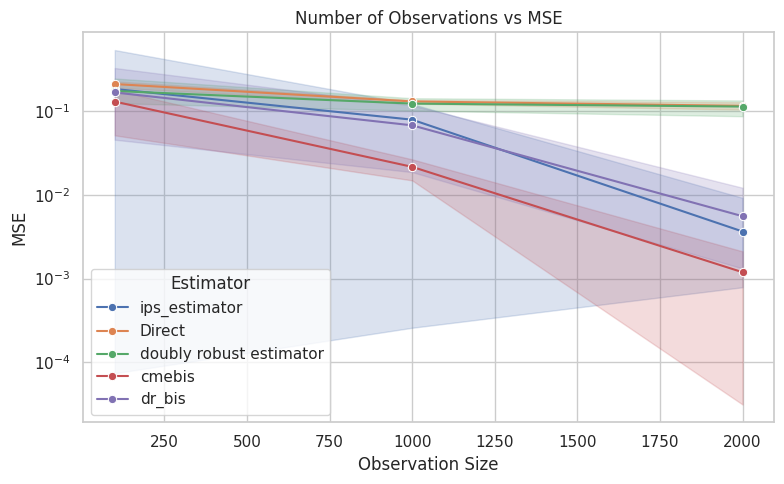

In [16]:

# Running the simulation
full_results = pd.concat(
    [simulate_observation_size(n, config, num_iter) for n in observation_sizes]
)

# Plotting results
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.lineplot(
    data=full_results, x="Observation Size", y="MSE", hue="Estimator", marker="o"
)
plt.yscale("log")
plt.title("Number of Observations vs MSE")
plt.tight_layout()
plt.show()

In [50]:
# full_results.loc[(full_results["Estimator"] == 'cmebis') | (full_results["Estimator"] == 'dr_bis') | (full_results["Estimator"] == 'ips_estimator')]

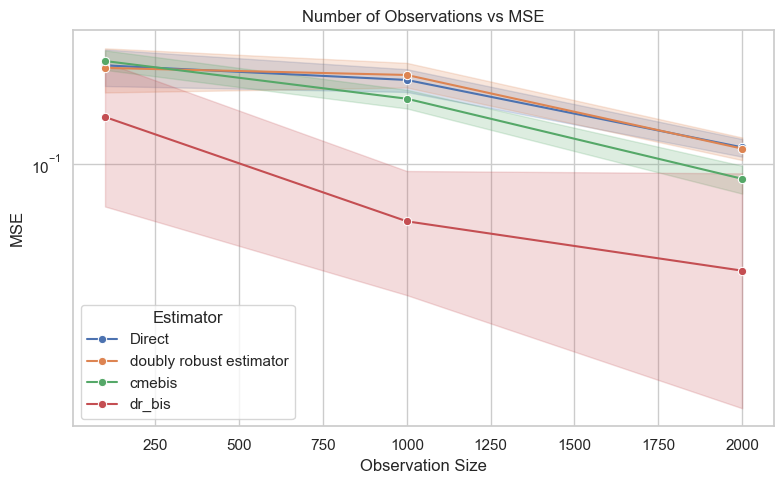

In [73]:
# Plotting results
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.lineplot(
    data=full_results[(full_results.Estimator != 'ips_estimator')], x="Observation Size", y="MSE", hue="Estimator", marker="o"
)
plt.yscale("log")
plt.title("Number of Observations vs MSE")
plt.tight_layout()
plt.show()

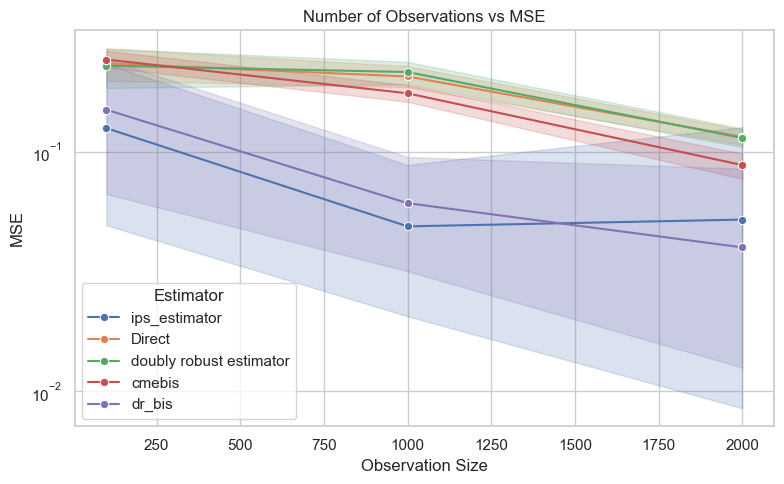

In [74]:
# Plotting results
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.lineplot(
    data=full_results[(full_results.Estimator != 'dr_cme_estimator')], x="Observation Size", y="MSE", hue="Estimator", marker="o"
)
plt.yscale("log")
plt.title("Number of Observations vs MSE")
plt.tight_layout()
plt.show()

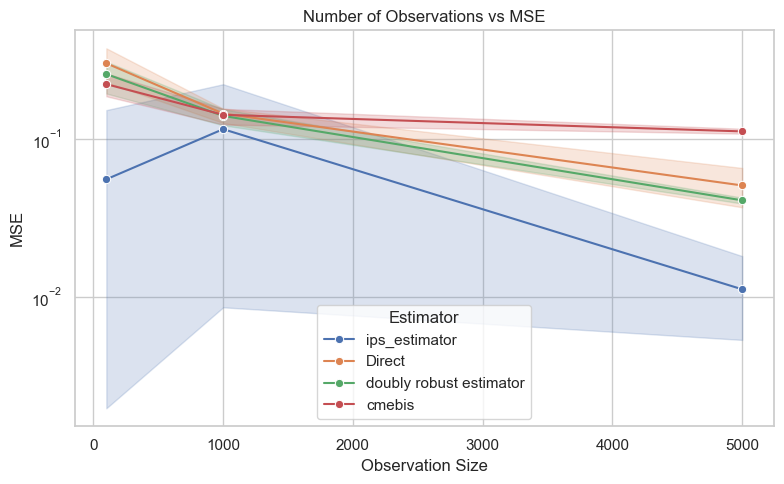

In [8]:
# Plotting results
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.lineplot(
    data=full_results[(full_results.Estimator != 'dr_cme_estimator') & (full_results.Estimator != 'dr_bis')], x="Observation Size", y="MSE", hue="Estimator", marker="o"
)
plt.yscale("log")
plt.title("Number of Observations vs MSE")
plt.tight_layout()
plt.show()

In [10]:
full_results[(full_results.Estimator == 'cmebis') | (full_results.Estimator == 'dr_bis')]

,Estimator,MSE,Observation Size
3,cmebis,0.179618,100
4,dr_bis,0.179615,100
8,cmebis,0.218795,100
9,dr_bis,0.218795,100
13,cmebis,0.111073,100
14,dr_bis,0.111073,100
18,cmebis,0.207412,100
19,dr_bis,0.207412,100
23,cmebis,0.144400,100
24,dr_bis,0.144400,100


In [65]:
import jax.numpy as jnp
import numpy as np

from kernel import Exponential, Gaussian, Linear, Polynomial, RationalQuadratic

settings = {"reg_lambda": 1e-5, "bandwidth": 1}


def _get_kernel(settings):
    if settings["kernel"] == "gauss":
        kernel = Gaussian(settings)
        return kernel
    elif settings["kernel"] == "exp":
        kernel = Exponential(settings)
        return kernel
    elif settings["kernel"] == "linear":
        return Linear(settings)
    elif settings["kernel"] == "polynomial":
        return Polynomial(settings)
    elif settings["kernel"] == "rq":
        return RationalQuadratic(settings)
    else:
        raise NotImplementedError

# === Generate simulation data ===
user_vectors = np.random.normal(0, 1, size=(config["n_users"], config["context_dim"]))
target_user_vectors = user_vectors * np.random.binomial(1, 0.5, size=user_vectors.shape)
item_vectors = np.random.normal(0, 1, size=(config["n_items"], config["context_dim"]))

alpha = -0.3
logging_user_vectors = alpha * target_user_vectors

logging_policy = MultinomialPolicy(item_vectors, logging_user_vectors, config["n_items"], config["n_reco"], temperature=0.5, cal_gamma=True)
target_policy = MultinomialPolicy(item_vectors, target_user_vectors, config["n_items"], config["n_reco"], temperature=1.0, cal_gamma=False)
environment = AvgEnvironment(item_vectors, user_vectors)

sim_data = []
for _ in range(obs_size):
        user = environment.get_context()

        logging_reco, logging_multinomial, logging_user_vector = logging_policy.recommend(user)
        target_reco, target_multinomial, _ = target_policy.recommend(user)

        sim_data.append({
        "logging_context_vec": logging_user_vector,
        "target_context_vec": logging_user_vector,
        "logging_reco": tuple(logging_reco),
        "logging_reco_vec": np.concatenate(item_vectors[logging_reco]),
        "logging_reward": environment.get_reward(user, logging_reco),
        "target_reco": tuple(target_reco),
        "target_multinomial": target_multinomial,
        "target_reco_vec": np.concatenate(item_vectors[target_reco]),
        "target_reward": environment.get_reward(user, target_reco),
        "logging_multinomial": logging_multinomial,
        "user": user,
        })

sim_data = pd.DataFrame(sim_data)





[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:    6.6s remaining:   26.3s
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    6.7s remaining:   15.7s
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    6.8s remaining:   10.2s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    6.9s remaining:    6.9s
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    6.9s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    6.9s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:    6.9s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.0s finished


In [66]:
sim_data

,logging_context_vec,target_context_vec,logging_reco,logging_reco_vec,logging_reward,target_reco,target_multinomial,target_reco_vec,target_reward,logging_multinomial,user
0,"[0.0, -0.0, -0.0, -0.0, 0.0]","[0.0, -0.0, -0.0, -0.0, 0.0]","(1, 8, 9, 12)","[-0.4358349834913552, 1.0254555700768233, -0.0...",0,"(14, 4, 1, 10)","[0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.0...","[-0.9256260367226805, -0.007830870008659103, 0...",1,"[0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.0...",3
1,"[0.21360987207871576, -0.10427410231936293, -0...","[0.21360987207871576, -0.10427410231936293, -0...","(12, 10, 7, 0)","[-0.19738179424941676, 1.671202072272812, 0.52...",0,"(10, 14, 18, 4)","[0.01928113420032203, 0.044598081638489266, 0....","[-1.1302463306404904, 1.792649223582581, 1.797...",1,"[0.05113150968816029, 0.04508801081519802, 0.0...",4
2,"[0.4198860787048842, -0.6548985850854564, 0.0,...","[0.4198860787048842, -0.6548985850854564, 0.0,...","(18, 12, 9, 14)","[0.8033827292065501, -0.8485841276216847, -1.3...",1,"(12, 1, 10, 3)","[0.006937848492731827, 0.0874633618800129, 3.9...","[-0.19738179424941676, 1.671202072272812, 0.52...",1,"[0.03087421454560486, 0.02111084973576335, 0.0...",6
3,"[0.7336180622814856, -0.0, 0.13477225277999974...","[0.7336180622814856, -0.0, 0.13477225277999974...","(15, 18, 8, 10)","[1.2453069458345865, -1.808832351576569, -0.41...",0,"(6, 14, 4, 19)","[0.0010365064283952786, 0.012724991417509159, ...","[-0.08561691521998496, -2.432704795533552, 1.1...",1,"[0.059601532697458603, 0.040916135046917206, 0...",2
4,"[0.0, -0.0, 0.0, 0.13965533269395988, -0.0]","[0.0, -0.0, 0.0, 0.13965533269395988, -0.0]","(9, 0, 1, 5)","[0.3243135942096038, -0.534208083105601, -2.02...",1,"(19, 1, 13, 17)","[0.08479518194694054, 0.05058248771086369, 0.0...","[-1.1321545545378595, 0.13894021470071974, -0....",0,"[0.045648771948166175, 0.04932700502439304, 0....",9
...,...,...,...,...,...,...,...,...,...,...,...
95,"[0.4198860787048842, -0.6548985850854564, 0.0,...","[0.4198860787048842, -0.6548985850854564, 0.0,...","(10, 4, 6, 8)","[-1.1302463306404904, 1.792649223582581, 1.797...",0,"(3, 10, 12, 1)","[0.006937848492731827, 0.0874633618800129, 3.9...","[0.971091487237171, 0.9379053443315658, 0.1426...",1,"[0.03087421454560486, 0.02111084973576335, 0.0...",6
96,"[0.0, -0.0, 0.0, 0.13965533269395988, -0.0]","[0.0, -0.0, 0.0, 0.13965533269395988, -0.0]","(9, 8, 15, 0)","[0.3243135942096038, -0.534208083105601, -2.02...",0,"(5, 4, 0, 11)","[0.08479518194694054, 0.05058248771086369, 0.0...","[0.20389014208127826, 0.19229645713387436, -1....",1,"[0.045648771948166175, 0.04932700502439304, 0....",9
97,"[0.0, -0.0, -0.0, -0.0, 0.0]","[0.0, -0.0, -0.0, -0.0, 0.0]","(13, 8, 19, 10)","[0.45511007858513264, -0.8853124209955955, -0....",1,"(7, 4, 16, 5)","[0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.0...","[0.3128786364001493, -0.15667751206607267, -0....",0,"[0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.0...",3
98,"[-0.0, 0.0, -0.05033205125250053, 0.0091219448...","[-0.0, 0.0, -0.05033205125250053, 0.0091219448...","(1, 18, 17, 13)","[-0.4358349834913552, 1.0254555700768233, -0.0...",1,"(8, 2, 10, 14)","[0.02600608757556106, 0.01146934361427036, 0.1...","[0.9342944225892453, -1.2239703760632892, -0.3...",1,"[0.04961203257006456, 0.05609413929572372, 0.0...",5


In [91]:
logging_context_vec = np.stack(
    sim_data["logging_context_vec"].dropna(axis=0).to_numpy()
)
logging_reco_vec = np.stack(
    sim_data["logging_reco_vec"].dropna(axis=0).to_numpy()
)
target_context_vec = np.stack(
    sim_data["target_context_vec"].dropna(axis=0).to_numpy()
)
target_reco_vec = np.stack(
    sim_data["target_reco_vec"].dropna(axis=0).to_numpy()
)
logging_reward = sim_data["logging_reward"].dropna(axis=0).values

target_reward = sim_data["target_reward"].dropna(axis=0).values

In [69]:
logging_context_vec.shape

(100, 5)

In [82]:
settings = {
    'reg_lambda': 0.1,
    'reg_lambda_tilde':0.01,
    'kernel': 'gauss',
    'bandwidth': 0.1,
}
reg_lambda = settings["reg_lambda"]
reg_lambda_1 = settings["reg_lambda_tilde"]

kernel_treatment = _get_kernel(settings)
kernel_covariates = _get_kernel(settings)

kernel_treatment.fit(logging_reco_vec)
kernel_covariates.fit(logging_context_vec)

K_T = kernel_treatment.gram_matrix(logging_reco_vec)
K_X = kernel_covariates.gram_matrix(logging_context_vec)

K_T_tilde = kernel_treatment.evaluate(logging_reco_vec, target_reco_vec)
K_X_tilde = kernel_covariates.evaluate(logging_context_vec, target_context_vec)

n = logging_context_vec.shape[0]
A_logging = np.multiply(K_X, K_T) + n * reg_lambda * np.eye(n)
b_logging = np.multiply(K_T_tilde, K_X_tilde)
inv_K_tilde_K =  np.linalg.solve(A_logging, b_logging)
np.mean(np.dot(logging_reward,inv_K_tilde_K))

In [85]:
K_T.shape, K_X.shape, K_T_tilde.shape, K_X_tilde.shape

((100, 100), (100, 100), (100, 100), (100, 100))

68.99219088443058

In [93]:
np.mean(logging_reward)

0.49

In [94]:
np.mean(target_reward)

0.67

In [ ]:



K_T_M_X = K_T * K_M * K_X + n * reg_lambda * jnp.eye(n)
K_T_X = K_T * K_X + n * reg_lambda_1 * jnp.eye(n)

def _kme_cross_conditional_mean_outcomes(d, d_prime, y, a, x):
    """
    Estimate the cross conditional mean outcome

    Parameters
    ----------
    y       array-like, shape (n_samples)
            outcome value for each unit, continuous

    t       array-like, shape (n_samples)
            treatment value for each unit, binary

    m       array-like, shape (n_samples)
            mediator value for each unit, here m is necessary binary and uni-
            dimensional

    x       array-like, shape (n_samples, n_features_covariates)
            covariates (potential confounders) values

    settings dictionary
            parameters for the kernel

    Returns
    -------
    mu_0m : array-like, shape (n_samples)
            conditional mean outcome for control group

    mu_1m : array-like, shape (n_samples)
            conditional mean outcome for treatment group

    psi_t0t0 : array-like, shape (n_samples)
            cross conditional mean outcome

    psi_t0t1 : array-like, shape (n_samples)
            cross conditional mean outcome

    psi_t1t0 : array-like, shape (n_samples)
            cross conditional mean outcome

    psi_t1t1 : array-like, shape (n_samples)
            cross conditional mean outcome
    """
    n = x.shape[0]

    reg_lambda = settings["reg_lambda"]
    reg_lambda_1 = settings["reg_lambda_tilde"]

    kernel_treatment = _get_kernel(settings)
    kernel_mediator = _get_kernel(settings)
    kernel_covariates = _get_kernel(settings)

    kernel_treatment.fit(t)
    kernel_mediator.fit(m)
    kernel_covariates.fit(x)

    K_T = kernel_treatment.gram_matrix(t)
    K_M = kernel_mediator.gram_matrix(m)
    K_X = kernel_covariates.gram_matrix(x)

    K_T_M_X = K_T * K_M * K_X + n * reg_lambda * jnp.eye(n)
    K_T_X = K_T * K_X + n * reg_lambda_1 * jnp.eye(n)

    inv_K_T_M_X = np.linalg.inv(K_T_M_X)
    inv_K_T_X = np.linalg.inv(K_T_X)

    K_M_inv_K_T_X = np.dot(K_M, inv_K_T_X)
    Y_inv_K_T_M_X = np.dot(y, inv_K_T_M_X)

    d = d * np.array([1])
    d_prime = d_prime * np.array([1])

    K_Td = kernel_treatment.evaluate(t, d)
    K_Td_prime = kernel_treatment.evaluate(t, d_prime)

    #
    half_d = np.dot(K_M_inv_K_T_X, K_Td * K_X) * K_X
    half_d_prime = np.dot(K_M_inv_K_T_X, K_Td_prime * K_X) * K_X

    # eta_tt
    psi_d_d = np.dot(Y_inv_K_T_M_X, K_Td * half_d)

    # eta_td
    psi_d_d_prime = np.dot(Y_inv_K_T_M_X, K_Td_prime * half_d)

    # eta_dt
    psi_d_prime_d = np.dot(Y_inv_K_T_M_X, K_Td * half_d_prime)

    # eta_dd
    psi_d_prime_d_prime = np.dot(Y_inv_K_T_M_X, K_Td_prime * half_d_prime)

    mu_d = np.dot(Y_inv_K_T_M_X, K_Td * K_M * K_X)
    mu_d_prime = np.dot(Y_inv_K_T_M_X, K_Td_prime * K_M * K_X)

    return mu_d, mu_d_prime, psi_d_d, psi_d_d_prime, psi_d_prime_d, psi_d_prime_d_prime


def _kme_conditional_mean_outcome(d, d_prime, y, t, m, x, settings):
    """
    Estimate the mediated response curve

    Parameters
    ----------
    y       array-like, shape (n_samples)
            outcome value for each unit, continuous

    t       array-like, shape (n_samples)
            treatment value for each unit, binary

    m       array-like, shape (n_samples)
            mediator value for each unit, here m is necessary binary and uni-
            dimensional

    x       array-like, shape (n_samples, n_features_covariates)
            covariates (potential confounders) values

    settings dictionary
            parameters for the kernel

    Returns
    -------
    eta_t0t0 : array-like, shape (n_samples)
            mediated response curve

    eta_t0t1 : array-like, shape (n_samples)
            mediated response curve

    eta_t1t0 : array-like, shape (n_samples)
            mediated response curve

    eta_t1t1 : array-like, shape (n_samples)
            mediated response curve
    """
    _, _, psi_d_d, psi_d_d_prime, psi_d_prime_d, psi_d_prime_d_prime = (
        _kme_cross_conditional_mean_outcomes(d, d_prime, y, t, m, x, settings)
    )

    # eta_t1t1
    eta_d_d = np.mean(psi_d_d)

    # eta_t1t0
    eta_d_d_prime = np.mean(psi_d_d_prime)

    # eta_t0t1
    eta_d_prime_d = np.mean(psi_d_prime_d)

    # eta_t0t0
    eta_d_prime_d_prime = np.mean(psi_d_prime_d_prime)

    return eta_d_d, eta_d_d_prime, eta_d_prime_d, eta_d_prime_d_prime